# CPO Notebook (with many assets)

In [45]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import time
import missingno

### Parameters

In [46]:
assets = ['SPX', 'SX5E', 'GOVIES EUR', 'GOVIES US', 'GOLD', 'WTI']
n_assets = len(assets)
N = 50  # combinations
rnd_seed = 42
date_start = '2020-01-30'

# Select metric for evaluation 1\2\3 (r2\mse\mae)
metric_choice = '1' # Must be in ' '

### Functions

In [47]:
def plot_feature_importance(model, feature_names, model_name):
    
    #Plots and prints the top 10 most important features.
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(10)


    # Plot the feature importance
    plt.figure(figsize=(8, 5))
    plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="steelblue")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title(f"Feature Importance - {model_name}")
    plt.gca().invert_yaxis()
    plt.show()

In [48]:
# Rolling Sharpe Ratio calculation
def rolling_sharpe_ratio(returns, window=30, risk_free_rate=0.00007858): # Daily risk-free considering 0.02% annual rate

    excess_returns = returns - risk_free_rate
    rolling_mean = pd.Series(excess_returns).rolling(window).mean()
    rolling_std = pd.Series(excess_returns).rolling(window).std()
    sharpe_ratio = rolling_mean / rolling_std

    # Replace infinities with 0
    sharpe_ratio.replace([np.inf, -np.inf], 0, inplace=True)
    
    # Ensure no NaN values
    sharpe_ratio.fillna(0, inplace=True)

    return sharpe_ratio

In [49]:
# Cross validation function

def time_grouped_cv(model, X, y):
    
    
    
    kf = KFold(n_splits=5, shuffle=False)
    scores = []
    
    combined_matrix_filtered = combined_matrix.loc[X.index].copy()
    combined_matrix_filtered['time_step'] = combined_matrix_filtered['time_step'].reset_index(drop=True)
    
    print("\nStarting Time-Grouped Cross-Validation...")
    for fold, (train_idx, test_idx) in enumerate(kf.split(np.unique(combined_matrix_filtered['time_step'])), start=1):
        '''
        log_and_print(f"Processing Fold {fold}/5...")'
        '''
        time.sleep(0.2)  # Just to make it more readable if running fast
        
        train_steps = combined_matrix_filtered['time_step'].iloc[train_idx].values
        test_steps = combined_matrix_filtered['time_step'].iloc[test_idx].values
        
        train_mask = combined_matrix_filtered['time_step'].isin(train_steps).values
        test_mask = combined_matrix_filtered['time_step'].isin(test_steps).values       
        
        X_train, X_test = X.loc[train_mask], X.loc[test_mask]
        y_train, y_test = y.loc[train_mask], y.loc[test_mask]        
                
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        # Calculate selected metric
        score = selected_metric_func(y_test, y_pred)
        scores.append(score)

        
    mean_score = np.mean(scores)

    return mean_score


In [50]:
# Based on the chosen metric the function evaluates the model
def evaluate_model(name, model, X_test, y_test, metric):
    y_pred = model.predict(X_test)
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    

    # Calculate Directional Accuracy
    y_pred_dir = np.sign(y_pred)
    y_test_dir = np.sign(y_test)
    directional_accuracy = np.mean(y_pred_dir == y_test_dir)
    
    # Display results based on selected metric
    print(f"\nEvaluating {name} Model...")
    print(f"{name} Model Results:")
    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Directional Accuracy: {directional_accuracy:.4f}")
    print("-" * 40)

    # Return selected metric score
    if metric == "R²":
        return r2
    elif metric == "MAE":
        return mae
    elif metric == "DA":
        return directional_accuracy
    else:
        raise ValueError(f"Invalid metric selected: {metric}")


In [51]:
def plot_feature_importances(model, feature_names, model_name):
    
    """Plots and prints the top 10 most important features."""
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(10)


    # Plot the feature importance
    plt.figure(figsize=(8, 5))
    plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="steelblue")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title(f"Feature Importance - {model_name}")
    plt.gca().invert_yaxis()
    plt.show()
    
def directional_accuracy(y_true, y_pred):
    """Calculates the percentage of times the predicted and actual returns have the same sign."""
    correct_directions = (np.sign(y_true) == np.sign(y_pred)).sum()
    return correct_directions / len(y_true)


In [52]:
def custom_random_search(model, param_grid, X, y, n_iter=10):
    best_score = -np.inf
    best_params = None
    feature_columns = X.columns.tolist()  # Get the feature names directly from X
        

    
    for i in range(n_iter):
        params = {k: np.random.choice(v) for k, v in param_grid.items()}
        model.set_params(**params)
        
        score = time_grouped_cv(model, X, y)

        
        if score > best_score:
            best_score = score
            best_params = params
    
    
    model.set_params(**best_params)    
    model.fit(X, y)
    # Feature Importance Extraction
    if hasattr(model, "feature_importances_"):
        plot_feature_importances(model, feature_columns, model.__class__.__name__)
    return model, best_score, best_params

In [53]:
def directional_accuracy(y_true, y_pred):
    """Calculates the percentage of times the predicted and actual returns have the same sign."""
    correct_directions = (np.sign(y_true) == np.sign(y_pred)).sum()
    return correct_directions / len(y_true)

### Features

In [54]:
def add_engineered_features(df):
   
    



    # Inflation differential
    df["inflation_diff"] = df["INFLEUR5Y"] - df["INFLUSD5Y"]
    
    # Volatility spread
    df["VIX_V2X_spread"] = df["VIX"] - df["V2X"]
    
    # Yield spreads
    df["EUR_yield_spread"] = df["5Y EUR RATE"] - df["3M EUR RATE"]
    df["USD_yield_spread"] = df["5Y USD RATE"] - df["3M USD RATE"]
    
    # FX spread
    df["EURUSD_EURJPY_spread"] = df["EURUSD"] - df["EURJPY"]
    
    # Commodity spread
    df["GOLD_WTI_spread"] = df["GOLD"] - df["WTI"]
    
    # Differenced features
    for col in ["VIX", "V2X", "MOVE", "EURUSD", "EURJPY", "GOLD", "5Y EUR RATE", "inflation_diff"]:
        df[f"{col}_diff"] = df[col].diff()
    
    # Interaction terms
    df["VIX_MOVE_interaction"] = df["VIX_diff"] * df["MOVE_diff"]
    df["VIX_EURUSD_interaction"] = df["VIX_diff"] * df["EURUSD_diff"]
    
    # Momentum Indicators: Rolling Averages (7-day and 30-day)
    for col in df.columns:
        if col.endswith('_diff'):
            df[f'{col}_ma7'] = df[col].rolling(window=7).mean()
            df[f'{col}_ma30'] = df[col].rolling(window=30).mean()

    # Volatility Clustering: Rolling Standard Deviations
    for col in ['VIX', 'V2X', 'MOVE']:
        df[f'{col}_volatility_7d'] = df[col].rolling(window=7).std()
        df[f'{col}_volatility_30d'] = df[col].rolling(window=30).std()

    # Non-linear Effects: Squared Terms
    for col in df.columns:
        if col.endswith('_diff'):
            df[f'{col}_squared'] = df[col] ** 2

    # Signal Ratios
    df['VIX_MOVE_ratio'] = df['VIX'] / df['MOVE'].replace(0, np.nan)
    df['EURUSD_VIX_ratio'] = df['EURUSD'] / df['VIX'].replace(0, np.nan)
    df['EUR_Inflation_Rate_ratio'] = df['5Y EUR RATE'] / df['INFLUSD5Y'].replace(0, np.nan)
    df['USD_Rate_Spread_ratio'] = df['5Y USD RATE'] / df['3M USD RATE'].replace(0, np.nan)
    




    # Daria's features
     # 1. FX Volatility Interaction
    df["FX_Vol_Interaction"] = df["VIX"] * df["EURUSD_diff"]
    
     # 2. Volatility Divergence
    df["Volatility_Divergence"] = df["VIX_diff"].rolling(5).mean() - df["MOVE_diff"].rolling(5).mean()
    
     # 3. Real Yield Spreads
    df["Real_Yield_Spread_US"] = df["5Y USD RATE"] - df["INFLUSD5Y"]
    df["Real_Yield_Spread_EUR"] = df["5Y EUR RATE"] - df["INFLEUR5Y"]
    
     # 4. Rate Momentum (2nd derivative approx)
    df["EUR_Rate_Momentum"] = df["5Y EUR RATE"].diff(1) - df["5Y EUR RATE"].diff(2)
    df["USD_Rate_Momentum"] = df["5Y USD RATE"].diff(1) - df["5Y USD RATE"].diff(2)
    
     # 5. FX Carry Spread
    df["FX_Carry_Spread"] = df["3M USD RATE"] - df["3M EUR RATE"]
    
     # 6. Gold/VIX Ratio
    df["Gold_VIX_ratio"] = df["GOLD"] / df["VIX"].replace(0, np.nan)
    
     # 7. VIX Volatility Gap
    df["VIX_volatility_7d"] = df["VIX"].rolling(window=7).std()
    df["VIX_volatility_30d"] = df["VIX"].rolling(window=30).std()
    df["VIX_vol_gap"] = df["VIX_volatility_7d"] - df["VIX_volatility_30d"]
    
     # 8. Flight to Safety Index
    df["GOLD_diff"] = df["GOLD"].diff()
    df["SP500_return"] = df["SPX"].pct_change()
    df["GOVIES_US_return"] = df["GOVIES US"].pct_change()
    df["Flight_to_Safety"] = df["GOLD_diff"].rolling(3).mean() + df["GOVIES_US_return"].rolling(3).mean() - df["SP500_return"].rolling(3).mean()

     # 9. Macro cointegration proxy
    df["EUR_US_Macro_Divergence"] = (
        (df["5Y EUR RATE"] - df["5Y USD RATE"]) +
        (df["INFLEUR5Y"] - df["INFLUSD5Y"]) +
        (df["3M EUR RATE"] - df["3M USD RATE"])
    )
    
    # 10. Liquidity pulse
    df["Liquidity_Pulse"] = df["BALTIC DRY IDX"].pct_change().rolling(7).mean() - df["MOVE"].rolling(7).mean()





    # Alberto's features
    # Slope of the Yield Curve (5Y vs 3M)
    df["USD_Yield_Slope"] = df["5Y USD RATE"] - df["3M USD RATE"]
    df["EUR_Yield_Slope"] = df["5Y EUR RATE"] - df["3M EUR RATE"]
    

    # Dynamic correlations
    df["VIX_SPX_Correlation"] = df["VIX"].rolling(window=30).corr(df["SPX"])
    df["EURUSD_GOLD_Correlation"] = df["EURUSD"].rolling(window=30).corr(df["GOLD"])


    # Indicator for economic shocks 
    df["Baltic_Dry_Shock"] = df["BALTIC DRY IDX"].pct_change().abs() > 0.1  # 10% change threshold
    df["Gold_Shock"] = df["GOLD"].pct_change().abs() > 0.05  
    df["WTI_Shock"] = df["WTI"].pct_change().abs() > 0.05


    # Expected Shortfall (CVaR)
    df["CVaR_95"] = df["SPX"].rolling(window=30).apply(lambda x: x[x <= x.quantile(0.05)].mean())


    # Mean commodities change
    df["Commodity_Cycle_Effect"] = (df["GOLD"].pct_change() + df["COPPER"].pct_change() + df["WTI"])/2


    # Time to Recession Indicator: Approximation based on yield spread
    df["Time_to_Recession"] = df["USD_Yield_Slope"].rolling(window=60).mean().shift(-1)  # Shifted to predict


    # Cross-Asset Momentum Interactions
    df["VIX_SPX_Momentum_Interaction"] = df["VIX"].diff() * df["SPX"].diff()
    df["EURUSD_GOLD_Momentum_Interaction"] = df["EURUSD"].diff() * df["GOLD"].diff()


    # Non-linear Interactions (Squared terms and their interactions)
    df["VIX_Squared"] = df["VIX"] ** 2
    df["EURUSD_Squared"] = df["EURUSD"] ** 2
    df["VIX_EURUSD_Interaction"] = df["VIX"] * df["EURUSD"]


    # Lead-Lag Effect: Checking how past values of VIX lead to SPX movement
    df["VIX_SPX_Lead_Lag"] = df["VIX"].shift(5) - df["SPX"].shift(5)


    # Lead-Lag between EURUSD and GOLD
    df["EURUSD_GOLD_Lead_Lag"] = df["EURUSD"].shift(5) - df["GOLD"].shift(5)



    # Reorganized data lists
    currencies_and_interest_rates = ["MOVE", "EURUSD", "EURJPY", "5Y EUR RATE", "3M EUR RATE", "5Y USD RATE", "3M USD RATE", "inflation_diff"]
    commodities_and_energy = ["COPPER", "COM ENERGY", "COM INDM", "COM AGR", "COM PREM", "BALTIC DRY IDX"]
    us_sector_indices = ["S&P 500 ENERGY", "S&P 500 MATERIALS", "S&P 500 UTILITIES", "S&P 500 INDUSTRIA", "S&P 500 CONS STAPL", "S&P 500 COMM", "S&P 500 REAL ESTA", "S&P 500 FINANCIALS", "S&P 500 HEALTH CA", "S&P 500 INFO TECH", "S&P 500 CONS DISCR"]
    eu_sector_indices = ["SX6P Index", "SXDP Index", "SX7P Index", "SXIP Index", "SX8P Index", "SXTP Index", "SX3P Index", "SXOP Index", "SXEP Index", "SX4P Index", "SXAP Index", "SXNP Index", "SXRP Index", "SXKP Index", "SXFP Index", "SXMP Index", "SXQP Index"]
    stocks_and_international_markets = ["MXWO", "EQ CHINA", "EQ PEXJP", "EQ LAT"]
    sovereign_debt = ["GOVIES ITA", "GOVIES SW", "GOVIES EM", "GOVIES JP"]
    corporate_debt = ["CORP EUR", "CORP US", "CORP HY US", "CORP HY EUR"]
    yield_rates = ["RF_US", "RF_EU"]
    eps = ["US_EPS", "EU_EPS"]

    
    # Mean changes in sectors 
    for i in range(len(currencies_and_interest_rates)):
        df["rates_mean_change"] = df[currencies_and_interest_rates].pct_change().mean(axis=1)
    for i in range(len(commodities_and_energy)):
        df["commodities_mean_change"] = df[commodities_and_energy].pct_change().mean(axis=1)
    for i in range(len(us_sector_indices)):
        df["us_sector_indices_mean_change"] = df[us_sector_indices].pct_change().mean(axis=1)
    for i in range(len(eu_sector_indices)):
        df["global_sector_indices_mean_change"] = df[eu_sector_indices].pct_change().mean(axis=1)
    for i in range(len(stocks_and_international_markets)):
        df["international_markets_mean_change"] = df[stocks_and_international_markets].pct_change().mean(axis=1)
    for i in range(len(sovereign_debt)):
        df["sovereign_debt_mean_change"] = df[sovereign_debt].pct_change().mean(axis=1)
    for i in range(len(corporate_debt)):
        df["corporate_debt_mean_change"] = df[corporate_debt].pct_change().mean(axis=1)



    # Substituing price time series with returns
    raw_prices = currencies_and_interest_rates + commodities_and_energy + us_sector_indices + eu_sector_indices + stocks_and_international_markets + corporate_debt + yield_rates + eps 
    df[raw_prices] = df[raw_prices].pct_change()




    # Drop NaN rows after diff()
    df.dropna(inplace=True)
    
    return df

### Hyperparameters

In [55]:
# Define hyperparameter grids

gbr_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10, 20, 30],    # Added regularization
    'min_samples_leaf': [1, 2, 4]               # Added regularization
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],              # Added regularization
    'gamma': [0, 0.1, 0.2],                     # Added regularization
    'reg_alpha': [0, 0.1, 0.5],                 # L1 regularization (lasso)
    'reg_lambda': [1, 1.5, 2.0, 3.0]            # L2 regularization (ridge)
}

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],           # Added regularization
    'max_samples': [0.5, 0.75, 1.0]             # Added regularization
}


### Insert parameters

In [56]:
# Map choice to metric
metric_map = {
    "1": ("R²", r2_score),
    "2": ("MAE", mean_absolute_error),
    "3": ("DA", directional_accuracy)
}

# Get selected metric
if metric_choice not in metric_map:
    print()
    print("Invalid choice. Defaulting to R².")
    selected_metric_name, selected_metric_func = metric_map["1"]
else:
    selected_metric_name, selected_metric_func = metric_map[metric_choice]
print()
print(f"Selected metric: {selected_metric_name}")



Selected metric: R²


### Load data

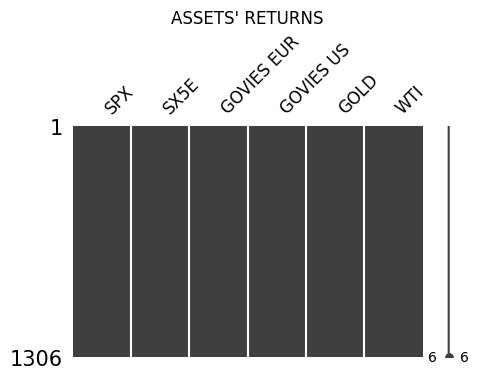

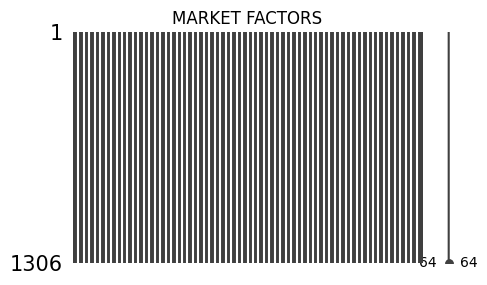

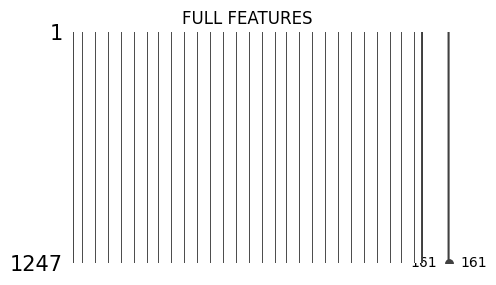

In [57]:
# Load real data
filename = 'data.xlsx'


data = pd.read_excel(filename, header=3, sheet_name='Sheet1')
data.set_index('date', inplace=True)
data = data[date_start:]



missingno.matrix(data[assets],figsize=(5,3), fontsize=12)
plt.title("ASSETS' RETURNS")
plt.show()

missingno.matrix(data.drop(assets, axis=1),figsize=(5,3), fontsize=12)
plt.title("MARKET FACTORS")
plt.show()

data = add_engineered_features(data)

missingno.matrix(data,figsize=(5,3), fontsize=12)
plt.title("FULL FEATURES")
plt.show()


# Calculate returns for the first 4 columns (assets) and drop NaN rows
data[assets] = data[assets].pct_change() # 
data = data.dropna()

# Extract asset returns (4 assets) and features (15 features)
asset_returns = data[assets]
features = data.drop(assets, axis=1)


### Random weights

In [58]:

# Generate random weight combinations using Dirichlet distribution
np.random.seed(rnd_seed)
random_weights = np.random.dirichlet(np.ones(n_assets), size=N)

# Convert to DataFrame
columns = []
for i in range(n_assets):
    columns.append('w'+str(i+1))

portfolio_weights = pd.DataFrame(random_weights, columns=columns)

print(portfolio_weights.head())

         w1        w2        w3        w4        w5        w6
0  0.077587  0.497681  0.217705  0.150942  0.028045  0.028040
1  0.007725  0.259656  0.118656  0.158958  0.002685  0.452319
2  0.505342  0.067520  0.056768  0.057314  0.102615  0.210441
3  0.201391  0.122580  0.337008  0.053499  0.123040  0.162483
4  0.150849  0.380988  0.055178  0.178866  0.222336  0.011783


### Combined matrix

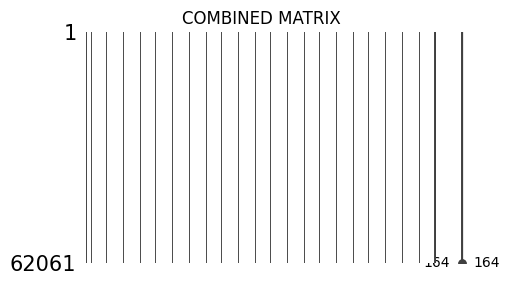

,w1,w2,w3,w4,w5,w6,VIX,V2X,INFLEUR5Y,INFLUSD5Y,...,rates_mean_change,commodities_mean_change,us_sector_indices_mean_change,global_sector_indices_mean_change,international_markets_mean_change,sovereign_debt_mean_change,corporate_debt_mean_change,portfolio_return,sharpe_ratio,time_step
0,0.178667,0.033040,0.202479,0.084315,0.475988,0.025511,41.98,43.9569,0.73,0.3132,...,-0.010133,0.018795,0.021599,0.018259,0.010079,-0.001134,-0.000939,0.011595,-0.802484,0
1,0.063210,0.018251,0.391895,0.317968,0.045207,0.163469,41.98,43.9569,0.73,0.3132,...,-0.010133,0.018795,0.021599,0.018259,0.010079,-0.001134,-0.000939,-0.039451,-0.857364,0
2,0.287385,0.136994,0.127549,0.046820,0.016526,0.384726,41.98,43.9569,0.73,0.3132,...,-0.010133,0.018795,0.021599,0.018259,0.010079,-0.001134,-0.000939,-0.086292,-0.889622,0
3,0.298742,0.129852,0.053622,0.055632,0.167642,0.294510,41.98,43.9569,0.73,0.3132,...,-0.010133,0.018795,0.021599,0.018259,0.010079,-0.001134,-0.000939,-0.059208,-0.896292,0
4,0.299836,0.208066,0.141222,0.012082,0.024235,0.314558,41.98,43.9569,0.73,0.3132,...,-0.010133,0.018795,0.021599,0.018259,0.010079,-0.001134,-0.000939,-0.067262,-0.906927,0
5,0.402235,0.003986,0.046154,0.469814,0.002189,0.075623,41.98,43.9569,0.73,0.3132,...,-0.010133,0.018795,0.021599,0.018259,0.010079,-0.001134,-0.000939,-0.011049,-0.958355,0
6,0.165817,0.245343,0.219946,0.052921,0.259535,0.056438,41.98,43.9569,0.73,0.3132,...,-0.010133,0.018795,0.021599,0.018259,0.010079,-0.001134,-0.000939,0.000612,-0.906723,0
7,0.059474,0.207349,0.158459,0.285855,0.161940,0.126922,41.98,43.9569,0.73,0.3132,...,-0.010133,0.018795,0.021599,0.018259,0.010079,-0.001134,-0.000939,-0.023344,-0.886041,0
8,0.018712,0.087212,0.058626,0.053212,0.687230,0.095007,41.98,43.9569,0.73,0.3132,...,-0.010133,0.018795,0.021599,0.018259,0.010079,-0.001134,-0.000939,-0.001616,-0.846318,0
9,0.316017,0.141584,0.224844,0.099152,0.122110,0.096292,41.98,43.9569,0.73,0.3132,...,-0.010133,0.018795,0.021599,0.018259,0.010079,-0.001134,-0.000939,-0.011654,-0.814223,0


In [59]:
# Number of time steps (T) and portfolios (N)
T = len(features)
N = len(portfolio_weights)


### Weights-Features matrix ###
# Create the correct NxT matrix
features_repeated = features.loc[features.index.repeat(N)].reset_index(drop=True) # Repeat each row of features N times
portfolio_repeated = pd.DataFrame(   # Tile (cycle) portfolio weights T times so they align with features
    np.tile(portfolio_weights, (T, 1)),
    columns=columns)
combined_matrix = pd.concat([portfolio_repeated, features_repeated], axis=1) # Combine features and weights side by side


### Adding PTF returns ###
# Recalculate portfolio returns using weights and asset returns
portfolio_returns = np.sum(portfolio_repeated.values * asset_returns.loc[asset_returns.index.repeat(N)].values, axis=1)
portfolio_returns_df = pd.DataFrame(portfolio_returns, columns=['portfolio_return'])  # Convert to DataFrame for consistency
combined_matrix['portfolio_return'] = portfolio_returns_df['portfolio_return'].values # Add portfolio returns to the combined matrix
combined_matrix['portfolio_return'] = portfolio_returns_df['portfolio_return'].values # Add portfolio returns to the combined matrix


### Adding Sharpe Ratios ###
combined_matrix['sharpe_ratio'] = rolling_sharpe_ratio(combined_matrix['portfolio_return'], window=30) # Calculate Sharpe ratios for all rows (NxT)
combined_matrix['sharpe_ratio'].fillna(0, inplace=True) # Handle NaNs by replacing with zero 
combined_matrix = combined_matrix[combined_matrix['sharpe_ratio'] != 0].reset_index(drop=True) # Remove rows where Sharpe ratio is NaN or zero


# Group rows by time steps
time_steps = np.arange(len(features))
combined_matrix['time_step'] = np.repeat(time_steps, N)[:len(combined_matrix)] # Assign time step groups, repeated N times (so rows for t1-tN are grouped)


### Checks ###
missingno.matrix(combined_matrix,figsize=(5,3), fontsize=12)
plt.title("COMBINED MATRIX")
plt.show()

# Now the combined matrix has the following structure: weights, features, portfolio returns, sharpe ratio, time steps (0x50-Nx50)
display(combined_matrix.head(10))



### Prediction Matrix

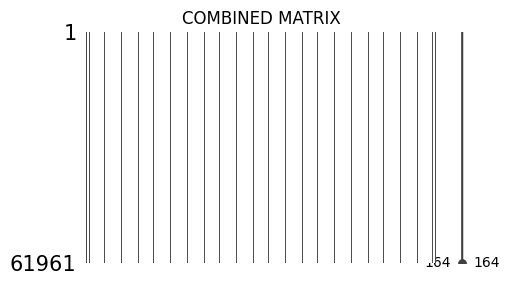

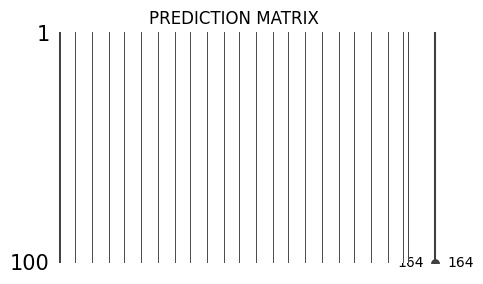

X shape: (61961, 161), y shape: (61961,)
Matching indices: True


In [60]:
# PREDICTION MATRIX
N_P = 2 # how many time step to predict from bottom
predict_matrix = combined_matrix[(-N*N_P):]
combined_matrix = combined_matrix[0:(-N*N_P)]


### Checks ###
missingno.matrix(combined_matrix,figsize=(5,3), fontsize=12)
plt.title("COMBINED MATRIX")
plt.show()

missingno.matrix(predict_matrix,figsize=(5,3), fontsize=12)
plt.title("PREDICTION MATRIX")
plt.show()


# Prepare features (X) and target (y)
X = combined_matrix.drop(columns=['sharpe_ratio', 'portfolio_return', 'time_step'])
y = combined_matrix['sharpe_ratio']

# Ensure indices of X and y match
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Matching indices: {(X.index == y.index).all()}")

# Split data into training and testing sets
split_idx = int(len(X) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]



### Model Training


Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...


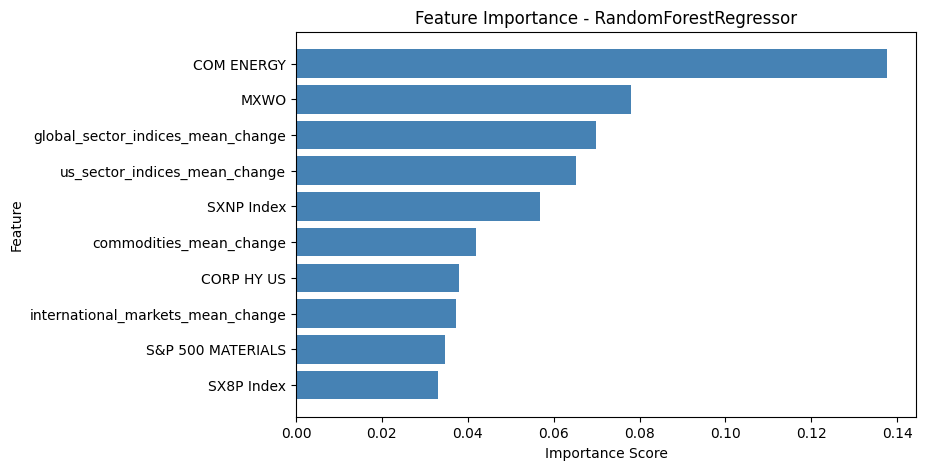


Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...


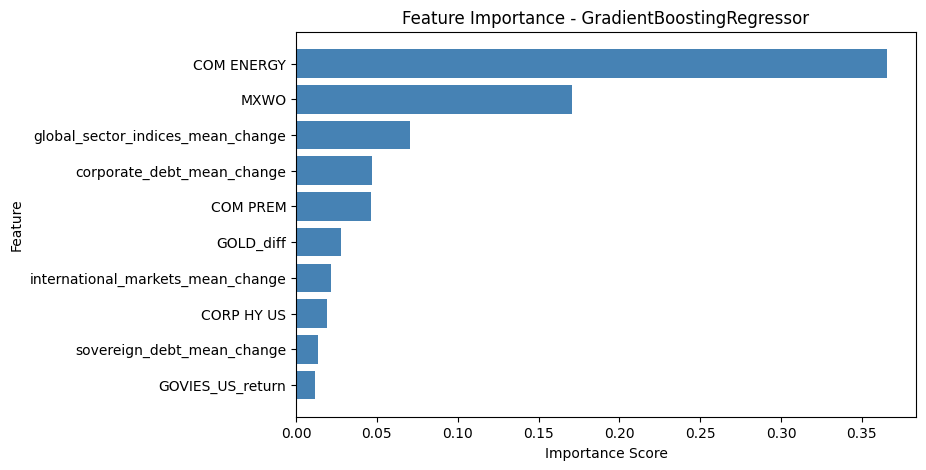


Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...

Starting Time-Grouped Cross-Validation...


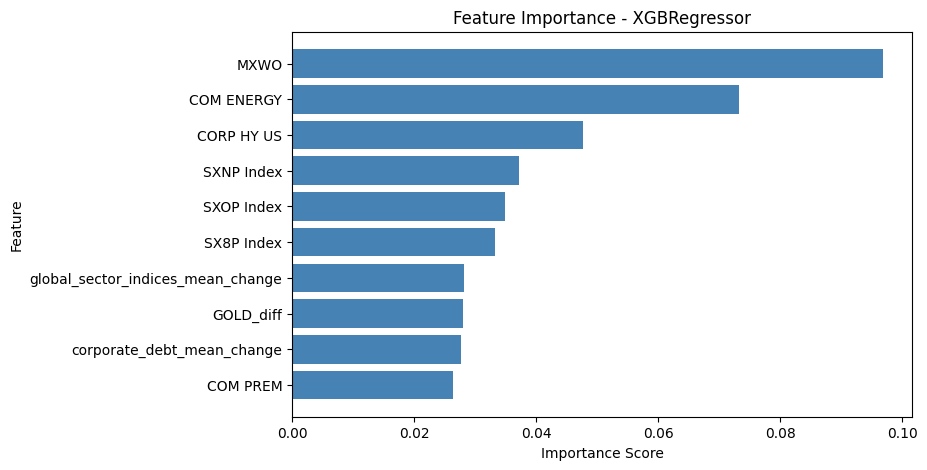


Best Random Forest hyperparameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_samples': 0.5}
Regularization params (RF): max_features=sqrt, max_samples=0.5

Best Gradient Boosting hyperparameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'min_samples_split': 5, 'min_samples_leaf': 2}
Regularization params (GBR): min_samples_split=5, min_samples_leaf=2

Best XGBoost hyperparameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'subsample': 0.9, 'min_child_weight': 3, 'gamma': 0.2, 'reg_alpha': 0.5, 'reg_lambda': 1.5}
Regularization params (XGB): min_child_weight=3, gamma=0.2, reg_alpha=0.5, reg_lambda=1.5

Evaluating Random Forest Model...
Random Forest Model Results:
R²: 0.3844
MSE: 1.2491
MAE: 0.8565
Directional Accuracy: 0.7472
----------------------------------------

Evaluating Gradient Boosting Model...
Gradient Boosting Model Result

In [61]:
gbr = GradientBoostingRegressor(random_state=rnd_seed)
rf = RandomForestRegressor(random_state=rnd_seed)
xgb = XGBRegressor(random_state=rnd_seed)

# Random search with time grouping
rf_best_model, rf_best_score, rf_best_params = custom_random_search(rf, rf_params, X_train, y_train)
gbr_best_model, gbr_best_score, gbr_best_params = custom_random_search(gbr, gbr_params, X_train, y_train)
xgb_best_model, xgb_best_score, xgb_best_params = custom_random_search(xgb, xgb_params, X_train, y_train)


print("\nBest Random Forest hyperparameters:", rf_best_params)
print("Regularization params (RF): max_features={}, max_samples={}".format(
    rf_best_params.get('max_features'), rf_best_params.get('max_samples')))

print("\nBest Gradient Boosting hyperparameters:", gbr_best_params)
print("Regularization params (GBR): min_samples_split={}, min_samples_leaf={}".format(
    gbr_best_params.get('min_samples_split'), gbr_best_params.get('min_samples_leaf')))

print("\nBest XGBoost hyperparameters:", xgb_best_params)
print("Regularization params (XGB): min_child_weight={}, gamma={}, reg_alpha={}, reg_lambda={}".format(
    xgb_best_params.get('min_child_weight'), 
    xgb_best_params.get('gamma'),
    xgb_best_params.get('reg_alpha'),
    xgb_best_params.get('reg_lambda')))

_ = evaluate_model("Random Forest", rf_best_model, X_test, y_test,"MAE")
_ = evaluate_model("Gradient Boosting", gbr_best_model, X_test, y_test,"MAE")
_ = evaluate_model("XGBoost", xgb_best_model, X_test, y_test,"MAE")


# prediction
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
X_pred = predict_matrix.drop(columns=['sharpe_ratio', 'portfolio_return', 'time_step'])

yhat_rf = rf_best_model.predict(X_pred)
yhat_gbr = gbr_best_model.predict(X_pred)
yhat_xgb = xgb_best_model.predict(X_pred)

X_pred['yhat_rf'] = yhat_rf
X_pred['yhat_gbr'] = yhat_gbr
X_pred['yhat_xgb'] = yhat_xgb

W_rf = X_pred[X_pred['yhat_rf'] == X_pred['yhat_rf'].max()].iloc[:,0:4]
W_gbr = X_pred[X_pred['yhat_gbr'] == X_pred['yhat_gbr'].max()].iloc[:,0:4]
W_xgb = X_pred[X_pred['yhat_xgb'] == X_pred['yhat_xgb'].max()].iloc[:,0:4]



